# Modeling - Bike Share System in the SF Bay Area

Author: Owen Hsu

## Table of content

1. Loading and Setup
2. Assessment
3. Spliting Training Set into Training and Validation Sets
4. Baseline Modeling
   * Logistic Regression
   * Decision Tree
   * Random Forest
   * XGBoost
   * Support Vector Machine (SVM)
   * K-Nearest Neighbors (KNN)

## Loading and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

/Users/chih-kanghsu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the datasets
train_df = pd.read_parquet('data/train_dataset.parquet')
test_df = pd.read_parquet('data/test_dataset.parquet')

## Assessment

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Train Data

In [4]:
# Print the shape of the train data
train_df.shape

(11831433, 17)

In [5]:
# Look at the first 5 rows of the train dataset
train_df.head()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
0,-1.375345,-0.667162,-0.099799,-0.428081,0.388370,0.306077,-1.406683,-0.436337,-1.014580,1.820021,1.582616,-0.168116,-1.310568,-0.195224,1.228122,-1.303354,1.0
1,1.125367,0.336991,0.776477,0.410568,-0.153740,0.306077,1.015281,-0.436337,0.779536,-0.548136,1.582616,-0.168116,0.428313,0.145410,0.216731,-0.434267,1.0
2,1.125367,0.336991,-1.122121,0.410568,2.014700,-0.455251,-0.195701,-0.436337,-0.566051,-0.548136,-0.631865,-0.168116,-1.600382,0.713132,-1.372598,-0.723963,0.0
3,0.083403,-0.667162,-0.537937,1.715132,0.543259,-2.739235,-1.103938,-0.436337,0.779536,-0.548136,1.582616,-0.168116,-1.600382,-0.535857,0.939153,-0.434267,1.0
4,0.125082,-0.667162,0.776477,1.062850,-0.463517,0.306077,0.712536,-0.436337,0.331007,-0.548136,-0.631865,-0.168116,1.007940,-0.762946,0.650184,1.593602,1.0


In [6]:
# Verify the train dataset
train_df.sample(10)

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
7051954,-0.333382,-1.671316,0.046247,-0.521264,0.156037,0.306077,0.107045,-0.436337,-1.463109,-0.091454,-0.631865,-0.168116,-0.730941,0.145410,-0.790403,-0.144572,0.0
2838323,-1.125274,-0.667162,0.922523,0.596934,-0.618405,0.306077,0.107045,-0.436337,1.228065,1.820021,1.582616,-0.168116,0.428313,-1.444213,-0.072238,-0.723963,1.0
6621496,-0.666810,-0.667162,-0.099799,0.410568,1.240257,0.306077,-1.103938,-0.436337,-1.463109,-0.703502,-0.631865,-0.168116,1.587567,0.826677,-0.379276,-1.593049,0.0
3431378,-0.791846,-0.667162,0.338339,2.274230,2.014700,-2.739235,-1.406683,-0.436337,0.779536,-0.651713,1.582616,-0.168116,-1.600382,0.258954,1.517091,0.724515,1.0
3292018,1.167046,0.336991,-0.537937,1.621949,1.240257,0.306077,-1.103938,-0.436337,0.331007,-0.548136,1.582616,-0.168116,1.587567,-0.308768,-0.216723,-0.434267,1.0
10755195,-0.458418,-1.671316,1.214615,0.783300,-0.540961,0.306077,-0.801192,-0.436337,-1.463109,-0.703502,-0.631865,-0.168116,0.718126,1.621488,-1.007944,0.724515,2.0
6210161,0.171183,-0.667162,-0.537937,-1.173546,-0.231184,0.306077,-0.801192,2.291809,1.676595,-0.548136,-0.631865,-0.168116,1.297754,-0.422313,0.650184,-1.217035,0.0
6575897,-0.875203,1.843221,1.068569,2.460597,2.092144,-1.216579,-1.406683,-0.436337,1.676595,-0.651713,1.582616,-0.168116,1.587567,0.599588,0.597199,-1.303354,0.0
4040996,-0.250025,-1.671316,-1.560259,-0.334897,2.324477,-2.739235,-0.801192,-0.436337,0.331007,-0.091454,-0.631865,-0.168116,-1.600382,-1.217124,-1.228114,1.014211,1.0
3152507,0.291796,1.341144,0.484385,1.062850,-3.019177,-2.739235,2.226264,2.291809,2.125124,-0.548136,-0.631865,-0.168116,1.587567,-0.535857,-0.794660,0.145124,0.0


In [7]:
# Get a quick overview of dataset variables
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11831433 entries, 0 to 11831432
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   station_id                      float64
 1   dock_count                      float64
 2   mean_dew_point_f                float64
 3   mean_humidity                   float64
 4   mean_sea_level_pressure_inches  float64
 5   mean_visibility_miles           float64
 6   mean_wind_speed_mph             float64
 7   precipitation_inches            float64
 8   cloud_cover                     float64
 9   zip_code                        float64
 10  weekend                         float64
 11  holiday                         float64
 12  month                           float64
 13  day                             float64
 14  hour                            float64
 15  minute                          float64
 16  usage_rate_category             float64
dtypes: float64(17)
memory usa

In [8]:
# Get a statistical summary of the dataset
train_df.describe()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
count,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07,1.183143e+07
mean,8.732592e-02,4.539910e-02,6.204326e-04,2.849624e-02,1.324608e-02,-3.006019e-02,3.542715e-02,2.947676e-02,4.194627e-02,-5.911522e-02,-2.994011e-02,-1.487793e-02,-5.402367e-03,1.451161e-03,-8.357365e-03,2.343803e-04,1.000000e+00
std,9.862928e-01,1.019173e+00,9.762112e-01,9.795185e-01,1.004865e+00,9.955866e-01,1.016665e+00,1.026560e+00,1.002547e+00,9.581601e-01,9.852097e-01,9.559194e-01,1.012743e+00,9.917042e-01,1.006497e+00,9.962533e-01,8.164966e-01
min,-1.708774e+00,-1.671316e+00,-5.357456e+00,-4.155406e+00,-3.019177e+00,-4.261891e+00,-2.012174e+00,-4.363365e-01,-1.463109e+00,-7.035020e-01,-6.318653e-01,-1.681160e-01,-1.600382e+00,-1.671302e+00,-1.661567e+00,-1.593049e+00,0.000000e+00
25%,-6.668103e-01,-6.671623e-01,-5.379373e-01,-4.280805e-01,-6.958494e-01,3.060765e-01,-8.011921e-01,-4.363365e-01,-1.014580e+00,-5.481358e-01,-6.318653e-01,-1.681160e-01,-1.020755e+00,-8.764904e-01,-9.302618e-01,-8.730440e-01,0.000000e+00
50%,2.084391e-01,-6.671623e-01,4.624675e-02,1.310183e-01,-1.537396e-01,3.060765e-01,-1.957009e-01,-4.363365e-01,-1.175220e-01,-5.481358e-01,-6.318653e-01,-1.681160e-01,1.384995e-01,3.186537e-02,-6.704320e-02,4.509445e-03,1.000000e+00
75%,9.586529e-01,3.369910e-01,7.764768e-01,5.969340e-01,7.755915e-01,3.060765e-01,7.125358e-01,-4.363365e-01,7.795363e-01,-9.145356e-02,1.582616e+00,-1.681160e-01,1.007940e+00,8.266767e-01,9.138567e-01,8.688470e-01,2.000000e+00
max,1.708867e+00,2.345298e+00,2.236937e+00,2.553780e+00,3.021475e+00,7.919356e+00,4.950974e+00,2.291809e+00,2.125124e+00,1.820021e+00,1.582616e+00,5.948273e+00,1.587567e+00,1.735032e+00,1.661576e+00,1.593602e+00,2.000000e+00


#### Test Data

In [9]:
# Print the shape of the test data
test_df.shape

(1467439, 17)

In [10]:
# Look at the first 5 rows of the test dataset
test_df.head()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
0,0.750260,2.345298,0.922523,0.596934,0.001149,0.306077,-0.801192,2.291809,0.779536,-0.548136,-0.631865,-0.168116,1.007940,0.826677,-1.083629,0.724515,2.0
1,-0.416739,-0.667162,0.776477,1.249216,-0.540961,-0.455251,0.107045,2.291809,-0.117522,-0.703502,-0.631865,-0.168116,1.587567,-0.649401,-1.661567,-0.434267,1.0
2,-0.375060,1.341144,0.192293,-0.800813,0.853036,0.306077,0.409790,-0.436337,-0.117522,-0.091454,1.582616,-0.168116,-1.020755,1.394399,-0.216723,-1.303354,2.0
3,1.333760,0.336991,0.922523,0.317385,-0.540961,0.306077,0.712536,-0.436337,0.779536,-0.548136,-0.631865,-0.168116,0.138499,1.735032,1.661576,0.724515,1.0
4,-1.667095,-0.667162,-0.537937,-0.893996,-0.463517,0.306077,0.712536,-0.436337,0.779536,1.820021,-0.631865,-0.168116,-0.441128,0.372499,-0.361207,0.145124,1.0


In [11]:
# Verify the test dataset
test_df.sample(10)

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
821127,-1.500381,-0.667162,-1.414213,-1.359912,1.627478,0.306077,-1.103938,-0.436337,-1.463109,1.820021,-0.631865,-0.168116,-1.020755,-1.103579,0.216731,-1.013658,1.0
1419674,-0.416739,-0.667162,0.922523,-0.334897,-0.773294,0.306077,0.107045,-0.436337,-0.117522,-0.703502,1.582616,-0.168116,0.428313,0.826677,-0.794660,0.724515,1.0
956811,0.458510,-0.667162,0.046247,-0.428081,0.853036,0.306077,2.831755,2.291809,0.779536,-0.548136,-0.631865,-0.168116,-0.441128,-0.762946,-1.228114,1.593602,1.0
117382,1.083688,1.341144,0.922523,0.037835,-2.012402,0.306077,0.409790,-0.436337,0.331007,-0.548136,-0.631865,-0.168116,0.718126,-1.444213,1.228122,-1.013658,1.0
867754,0.125082,-0.667162,-0.245845,1.435582,1.859811,-4.261891,-1.103938,2.291809,1.228065,-0.548136,-0.631865,-0.168116,-1.600382,0.031865,-0.505691,-1.013658,1.0
1373508,0.750260,2.345298,0.192293,-0.987179,-0.928182,0.306077,-0.801192,-0.436337,-1.014580,-0.548136,-0.631865,-0.168116,1.007940,-1.671302,-1.661567,1.014211,0.0
1124867,-1.417024,-0.667162,-0.245845,1.621949,-1.392848,-0.455251,-0.801192,2.291809,1.676595,1.820021,-0.631865,-0.168116,1.587567,-0.422313,-0.072238,-1.593049,0.0
542289,0.625225,0.336991,0.192293,-0.334897,-0.463517,0.306077,0.409790,-0.436337,-0.566051,-0.548136,-0.631865,-0.168116,-0.151314,-0.308768,0.216731,0.724515,1.0
566797,1.417117,2.345298,0.776477,0.410568,-0.153740,0.306077,1.015281,-0.436337,0.779536,-0.548136,1.582616,-0.168116,0.428313,0.145410,0.650184,1.014211,0.0
481885,1.083688,1.341144,-0.391891,-0.428081,0.001149,0.306077,3.134500,-0.436337,0.331007,-0.548136,-0.631865,-0.168116,-0.441128,-1.217124,1.661576,-1.303354,0.0


In [12]:
# Get a quick overview of dataset variables
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467439 entries, 0 to 1467438
Data columns (total 17 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   station_id                      1467439 non-null  float64
 1   dock_count                      1467439 non-null  float64
 2   mean_dew_point_f                1467439 non-null  float64
 3   mean_humidity                   1467439 non-null  float64
 4   mean_sea_level_pressure_inches  1467439 non-null  float64
 5   mean_visibility_miles           1467439 non-null  float64
 6   mean_wind_speed_mph             1467439 non-null  float64
 7   precipitation_inches            1467439 non-null  float64
 8   cloud_cover                     1467439 non-null  float64
 9   zip_code                        1467439 non-null  float64
 10  weekend                         1467439 non-null  float64
 11  holiday                         1467439 non-null  float64
 12  

In [13]:
# Get a statistical summary of the dataset
test_df.describe()

,station_id,dock_count,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,precipitation_inches,cloud_cover,zip_code,weekend,holiday,month,day,hour,minute,usage_rate_category
count,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06,1.467439e+06
mean,-1.110399e-03,-9.088503e-04,-2.253745e-04,1.104140e-03,8.589169e-05,6.632739e-04,1.124246e-03,5.678869e-04,2.040834e-03,2.704992e-04,3.843302e-04,-3.428524e-04,-3.142766e-05,-8.078574e-04,2.174742e-05,1.212700e-03,1.071246e+00
std,1.000178e+00,9.984484e-01,1.001204e+00,1.000368e+00,1.000515e+00,1.000051e+00,9.999969e-01,1.000527e+00,9.995878e-01,1.000361e+00,1.000183e+00,9.990089e-01,9.997948e-01,9.996474e-01,9.993584e-01,1.000312e+00,5.689108e-01
min,-1.708774e+00,-1.671316e+00,-5.357456e+00,-4.155406e+00,-3.019177e+00,-4.261891e+00,-2.012174e+00,-4.363365e-01,-1.463109e+00,-7.035020e-01,-6.318653e-01,-1.681160e-01,-1.600382e+00,-1.671302e+00,-1.661567e+00,-1.593049e+00,0.000000e+00
25%,-7.918459e-01,-6.671623e-01,-5.379373e-01,-5.212637e-01,-6.958494e-01,3.060765e-01,-8.011921e-01,-4.363365e-01,-1.014580e+00,-5.481358e-01,-6.318653e-01,-1.681160e-01,-7.309411e-01,-8.764904e-01,-7.946604e-01,-7.239626e-01,1.000000e+00
50%,-4.163215e-02,-6.671623e-01,4.624675e-02,3.783516e-02,-1.537396e-01,3.060765e-01,-1.957009e-01,-4.363365e-01,-1.175220e-01,-5.481358e-01,-6.318653e-01,-1.681160e-01,1.384995e-01,3.186537e-02,7.224641e-02,1.451240e-01,1.000000e+00
75%,8.752958e-01,3.369910e-01,7.764768e-01,5.969340e-01,6.981473e-01,3.060765e-01,7.125358e-01,-4.363365e-01,7.795363e-01,-9.145356e-02,1.582616e+00,-1.681160e-01,1.007940e+00,8.266767e-01,7.946688e-01,1.014211e+00,1.000000e+00
max,1.708867e+00,2.345298e+00,2.236937e+00,2.553780e+00,3.021475e+00,7.919356e+00,4.950974e+00,2.291809e+00,2.125124e+00,1.820021e+00,1.582616e+00,5.948273e+00,1.587567e+00,1.735032e+00,1.661576e+00,1.593602e+00,2.000000e+00


## Spliting Training Set into Training and Validation Sets

In [14]:
# Separate features and target variable from the train set
X_train_full = train_df.drop(columns=['usage_rate_category'])
y_train_full = train_df['usage_rate_category']

# Split the training dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Separate features and target variable from the test set
X_test = test_df.drop(columns=['usage_rate_category'])
y_test = test_df['usage_rate_category']

# Check the shapes of the datasets
print(f'Shape of test set: {X_train.shape}')
print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_test.shape}')

Shape of test set: (9465146, 16)
Shape of validation set: (2366287, 16)
Shape of train set: (1467439, 16)


## Baseline Modeling

#### Logistic Regression

Let's fit a logistic regression model on the data and analyze the test and train accuracy.

In [16]:
# Start the timer
start_time = time.time()

# Initialize the model
logreg = LogisticRegression(random_state=42)

# Fitting a model
logreg.fit(X_train, y_train)

# Get class predictions
y_pred_logreg = logreg.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
precision_logreg = precision_score(y_val, y_pred_logreg, average='macro')
recall_logreg = recall_score(y_val, y_pred_logreg, average='macro')
f1_logreg = f1_score(y_val, y_pred_logreg, average='macro')

# Training and test score
print('Logistic Regression')
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_val, y_val)}")

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_logreg))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logreg))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Logistic Regression
Train score: 0.39916795789520837
Test score: 0.39969623295906204

Confusion Matrix:
[[287923 248509 251837]
 [211851 357588 219460]
 [248069 240765 300285]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.39      0.37      0.37    788269
         1.0       0.42      0.45      0.44    788899
         2.0       0.39      0.38      0.38    789119

    accuracy                           0.40   2366287
   macro avg       0.40      0.40      0.40   2366287
weighted avg       0.40      0.40      0.40   2366287


Elapsed time: 20.41 seconds


#### Decision Tree

In [21]:
# Start the timer
start_time = time.time()

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Fitting a model
dt_model.fit(X_train, y_train);

# Get class predictions
y_pred_dt_model = dt_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_dt_model = accuracy_score(y_val, y_pred_dt_model)
precision_dt_model = precision_score(y_val, y_pred_dt_model, average='macro')
recall_dt_model = recall_score(y_val, y_pred_dt_model, average='macro')
f1_dt_model = f1_score(y_val, y_pred_dt_model, average='macro')

# Evaluate its classification accuracy
print('Decision Tree:')
print(f'Train score: {dt_model.score(X_train, y_train)}')
print(f'Test score: {dt_model.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_dt_model))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_model))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Decision Tree:
Train score: 1.0
Test score: 0.980181609415933

Confusion Matrix:
[[774722   7458   6089]
 [  8086 771209   9604]
 [  6324   9335 773460]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    788269
         1.0       0.98      0.98      0.98    788899
         2.0       0.98      0.98      0.98    789119

    accuracy                           0.98   2366287
   macro avg       0.98      0.98      0.98   2366287
weighted avg       0.98      0.98      0.98   2366287


Elapsed time: 238.01 seconds


#### Random Forest

In [22]:
# Start the timer
start_time = time.time()

# Initialize the model
random_forest_model = RandomForestClassifier(random_state=42)

# Fitting a model
random_forest_model.fit(X_train, y_train)

# Get class predictions
y_pred_random_forest_model = random_forest_model.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_random_forest_model = accuracy_score(y_val, y_pred_random_forest_model)
precision_random_forest_model = precision_score(y_val, y_pred_random_forest_model, average='macro')
recall_random_forest_model = recall_score(y_val, y_pred_random_forest_model, average='macro')
f1_random_forest_model = f1_score(y_val, y_pred_random_forest_model, average='macro')

# Evaluate its classification accuracy
print('Random Forest:')
print(f'Train score: {random_forest_model.score(X_train, y_train)}')
print(f'Test score: {random_forest_model.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_random_forest_model))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_random_forest_model))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

Random Forest:
Train score: 0.999997886984522
Test score: 0.9848467240026252

Confusion Matrix:
[[779375   5119   3775]
 [  7462 773460   7977]
 [  3584   7940 777595]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    788269
         1.0       0.98      0.98      0.98    788899
         2.0       0.99      0.99      0.99    789119

    accuracy                           0.98   2366287
   macro avg       0.98      0.98      0.98   2366287
weighted avg       0.98      0.98      0.98   2366287


Elapsed time: 8055.33 seconds


#### XGBoost

In [25]:
# Start the timer
start_time = time.time()

# Initialize the model
xgbc = XGBClassifier()

# Fitting a model
xgbc.fit(X_train, y_train)

# Get class predictions
y_pred_xgbc = xgbc.predict(X_val)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Saving metrics for plotting
accuracy_xgbc = accuracy_score(y_val, y_pred_xgbc)
precision_xgbc = precision_score(y_val, y_pred_xgbc, average='macro')
recall_xgbc = recall_score(y_val, y_pred_xgbc, average='macro')
f1_xgbc = f1_score(y_val, y_pred_xgbc, average='macro')

# Evaluate its classification accuracy
print('XGBoost:')
print(f'Train score: {xgbc.score(X_train, y_train)}')
print(f'Test score: {xgbc.score(X_val, y_val)}')

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgbc))

# Classification report 
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgbc))

# Print the elapsed time
print(f"\nElapsed time: {elapsed_time:.2f} seconds")

XGBoost:
Train score: 0.7412256504020117
Test score: 0.7410115510079716

Confusion Matrix:
[[557640 149844  80785]
 [ 41776 670623  76500]
 [ 89409 174527 525183]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76    788269
         1.0       0.67      0.85      0.75    788899
         2.0       0.77      0.67      0.71    789119

    accuracy                           0.74   2366287
   macro avg       0.75      0.74      0.74   2366287
weighted avg       0.75      0.74      0.74   2366287


Elapsed time: 174.61 seconds


#### Support Vector Machine (SVM)

Below is the code for SVM, this model can be trained in the future.

In [ ]:
# Start the timer
# start_time = time.time()

# Initialize the model
# svm = SVC(random_state=42)

# Fitting a model
# svm.fit(X_train, y_train)

# Stop the timer
# end_time = time.time()

# Calculate the elapsed time
# elapsed_time = end_time - start_time

# Evaluate its classification accuracy
# print('Support Vector Machine (SVM):')
# print(f'Train score: {svm.score(X_train, y_train)}')
# print(f'Test score: {svm.score(X_val, y_val)}')

# Get class predictions
# y_pred_svm = svm.predict(X_val)

# Generate confusion matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred_svm))

# Classification report 
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred_svm))

# Print the elapsed time
# print(f"\nElapsed time: {elapsed_time:.2f} seconds")

#### K-Nearest Neighbors (KNN)

Below is the code for KNN, this model can be trained in the future.

In [ ]:
# Start the timer
# start_time = time.time()

# Initialize the model
# KNN_model = KNeighborsClassifier(n_neighbors=3)

# Fitting a model
# KNN_model.fit(X_train, y_train)

# Stop the timer
# end_time = time.time()

# Calculate the elapsed time
# elapsed_time = end_time - start_time

# Evaluate its classification accuracy
# print('KNN:')
# print(f'Train score: {KNN_model.score(X_train, y_train)}')
# print(f'Test score: {KNN_model.score(X_val, y_val)}')

# Get class predictions
# y_pred_KNN_model = KNN_model.predict(X_val)

# Generate confusion matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_val, y_pred_KNN_model))

# Classification report 
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred_KNN_model))

# Print the elapsed time
# print(f"\nElapsed time: {elapsed_time:.2f} seconds")

#### Summary - Baseline Models

Let's review the training and testing scores, as well as the runtime for each model.

| Model               | Train Score (%) | Test Score (%) | Elapsed Time (seconds) |
|---------------------|-----------------|----------------|------------------------|
| Logistic Regression | 39.92%          | 39.97%         | 20.41                  |
| Decision Tree       | 100.00%         | 98.02%         | 238.01                 |
| Random Forest       | 99.99%          | 98.48%         | 8055.33                |
| XGBoost             | 74.12%          | 74.10%         | 174.61                 |


We can also compare the classification report for each model.

In [26]:
# Create an empty DataFrame to store the metrics
model_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
model_metrics_df.loc['Logistic Regression'] = [accuracy_logreg, precision_logreg, recall_logreg, f1_logreg]
model_metrics_df.loc['Decision Tree'] = [accuracy_dt_model, precision_dt_model, recall_dt_model, f1_dt_model]
model_metrics_df.loc['Random Forest'] = [accuracy_random_forest_model, precision_random_forest_model, recall_random_forest_model, f1_random_forest_model]
model_metrics_df.loc['XGBoost'] = [accuracy_xgbc, precision_xgbc, recall_xgbc, f1_xgbc]

# Show the comparison table
model_metrics_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.399696,0.398812,0.399689,0.398964
Decision Tree,0.980182,0.980181,0.980182,0.980181
Random Forest,0.984847,0.984844,0.984848,0.984845
XGBoost,0.741012,0.751028,0.741010,0.740226


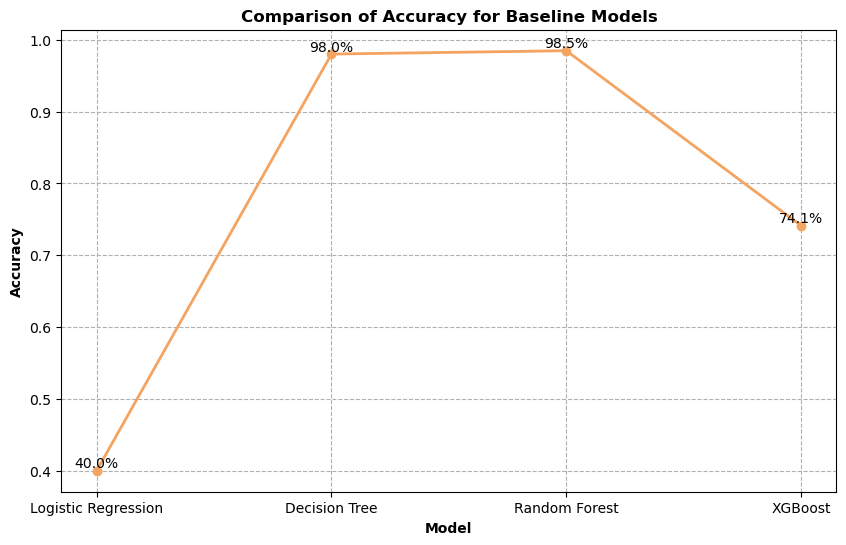

In [50]:
# Creating a list of model names
# Creating a list of model's corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_logreg, accuracy_dt_model, accuracy_random_forest_model, accuracy_xgbc]

# Plotting a line graph to compare the accuracy scores of each model
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='sandybrown', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Comparison of Accuracy for Baseline Models', fontweight='bold')

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

# Add grid lines
plt.grid(True, which='both', linestyle='--')  
plt.show()

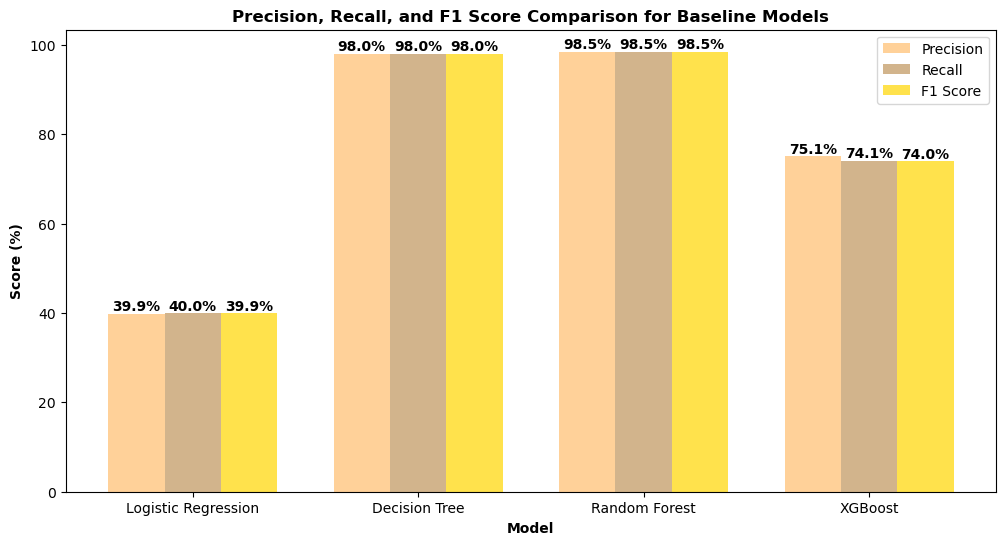

In [46]:
# Creating a list of model names
# Creating a list of model's corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_logreg, precision_dt_model, precision_random_forest_model, precision_xgbc]
recall_scores = [recall_logreg, recall_dt_model, recall_random_forest_model, recall_xgbc]
f1_scores = [f1_logreg, f1_dt_model, f1_random_forest_model, f1_xgbc]

# Converting scores to percentages with two decimal place
precision_scores_pct = [round(score * 100, 2) for score in precision_scores]
recall_scores_pct = [round(score * 100, 2) for score in recall_scores]
f1_scores_pct = [round(score * 100, 2) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plotting the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plotting the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='tan', label='Recall')

# Plotting the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='gold', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Baseline Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Adding score labels to the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()